# Using Scattertext and AgeFromName to find gender-discriminating terms

https://github.com/JasonKessler/scattertext

https://github.com/JasonKessler/agefromname

Cite as:
Jason S. Kessler. Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (ACL): System Demonstrations. 2017.

Link to preprint: https://arxiv.org/abs/1703.00565

`
@article{kessler2017scattertext,
  author    = {Kessler, Jason S.},
  title     = {Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ},
  booktitle = {ACL System Demonstrations},
  year      = {2017},
}
`

In [1]:
%matplotlib inline
import scattertext as st
import re, io, itertools
from pprint import pprint
import pandas as pd
import numpy as np
import spacy
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
# nlp = spacy.load('en')
# If this doesn't work, please uncomment the following line and use a regex-based parser instead
nlp = st.whitespace_nlp_with_sentences

In [3]:
convention_df = st.SampleCorpora.ConventionData2012.get_data()
convention_df['parsed'] = convention_df.text.apply(nlp)

## The `agefromname` package takes 
### - a first name,
### - optional: a minimum age,
### - optional: current year
## and returns
### - the probablity someone is male or female
### `pip install agefromname`

In [4]:
from agefromname import AgeFromName

In [5]:
gender_imputer = AgeFromName()

In [6]:
gender_imputer.prob_male('kelsey')

0.030994534772986027

In [7]:
gender_imputer.prob_male('kelsey', minimum_age=70)

0.7284493600641377

<AxesSubplot:xlabel='Year you encounter a Kelsey'>

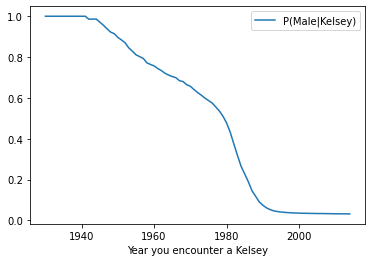

In [8]:
(pd.DataFrame([{'Year you encounter a Kelsey': year, 
                'P(Male|Kelsey)': gender_imputer.prob_male('kelsey', current_year=year)}
               for year in range(1930, 2015)])
 .set_index('Year you encounter a Kelsey')
 .plot())

In [9]:
gender_imputer.prob_male('cameron')

0.9077133032284712

In [10]:
gender_imputer.prob_male('cameron', minimum_age=21)

0.9152681165778421

In [14]:
gender_imputer.prob_male('cameron', minimum_age=21, current_year=2021)

0.9152681165778421

<AxesSubplot:xlabel='Year you encounter a Cameron'>

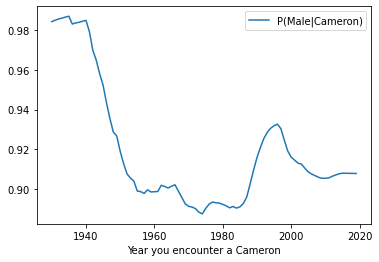

In [11]:
(pd.DataFrame([{'Year you encounter a Cameron': year, 
                'P(Male|Cameron)': gender_imputer.prob_male('cameron', current_year=year)}
               for year in range(1930, 2020)])
 .set_index('Year you encounter a Cameron')
 .plot())

<AxesSubplot:xlabel='Year you encounter a Sean'>

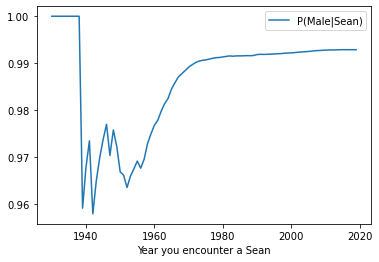

In [17]:
(pd.DataFrame([{'Year you encounter a Sean': year, 
                'P(Male|Sean)': gender_imputer.prob_male('sean', current_year=year)}
               for year in range(1930, 2020)])
 .set_index('Year you encounter a Sean')
 .plot())

## Let's assign speakers a gender if, assuming they're at least 35, 
## there's a 90% someone with their name is male or female.
## Otherwise, drop their speech from the dataset.

In [12]:
convention_df['speaker_gender'] = (convention_df.speaker
 .apply(lambda x: (gender_imputer.prob_male(x.split()[0], minimum_age = 35) if x else 0.5))
 .apply(lambda x: 'Male' if x > 0.9 else 'Female' if x < 0.1 else '?')
)

In [13]:
convention_df.iloc[:10]

,party,text,speaker,parsed,speaker_gender
0,democrat,Thank you. Thank you. Thank you. Thank you so ...,BARACK OBAMA,"(thank, you, ., thank, you, ., thank, you, ., ...",?
1,democrat,"Thank you so much. Tonight, I am so thrilled a...",MICHELLE OBAMA,"(thank, you, so, much, .)",Female
2,democrat,Thank you. It is a singular honor to be here t...,RICHARD DURBIN,"(thank, you, ., it, is, a, singular, honor, to...",Male
3,democrat,"Hey, Delaware. \nAnd my favorite Democrat, Jil...",JOSEPH BIDEN,"(hey, ,, delaware, ., and, my, favorite, democ...",Male
4,democrat,"Hello. \nThank you, Angie. I'm so proud of how...",JILL BIDEN,"(hello, ., thank, you, ,, angie, ., i, ', m, s...",Female
5,democrat,My name is Angie Flores and I am a student at ...,ANGIE FLORES,"(my, name, is, angie, flores, and, i, am, a, s...",Female
6,democrat,"Today and every day, our military men and wome...",JOHN NATHMAN,"(today, and, every, day, ,, our, military, men...",Male
7,democrat,Thank you. Thank you.\nIn this — in this campa...,JOHN KERRY,"(thank, you, ., thank, you, ., in, this, —, in...",Male
8,democrat,"Good evening. \nHalf a century ago, Ronald Rea...",CHARLIE CRIST,"(good, evening, ., half, a, century, ago, ,, r...",Male
9,democrat,Settle down. Settle down.\nI know Mitt Romney....,BRIAN SCHWEITZER,"(settle, down, ., settle, down, ., i, know, mi...",Male


In [18]:
convention_df.speaker_gender.value_counts()

Male      107
Female     63
?          19
Name: speaker_gender, dtype: int64

In [19]:
convention_df_gender = convention_df[convention_df.speaker_gender.isin(['Male', 'Female'])]
convention_df_gender['speaker_party'] = (convention_df_gender['speaker'] 
                                         + ' (' + convention_df_gender['party'].apply(lambda x: x.upper()[0])  + ')')

## Let's plot the differences in language use by gender

In [20]:
corpus_gender = st.CorpusFromParsedDocuments(convention_df_gender, 
                                             category_col='speaker_gender', 
                                             parsed_col='parsed').build()
html = st.produce_scattertext_explorer(corpus_gender,
                                       category='Female',
                                       category_name='Female',
                                       not_category_name='Male',
                                       minimum_term_frequency=5,
                                       width_in_pixels=1000,
                                       metadata=convention_df_gender['speaker_party'])
file_name = 'output/Conventions2012Gender.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=700)

# Let's see how gender and party-associated terms differ

## Compute gender and party scaled f-scores

In [21]:
female_scores = corpus_gender.get_scaled_f_scores('Female')
democratic_scores = (st.CorpusFromParsedDocuments(convention_df_gender, 
                                                  category_col='party', 
                                                  parsed_col='parsed')
                     .build()
                     .get_scaled_f_scores('democrat'))

# Use custom coordinates to plot the gender scaled f-score vs. the party scaled f-score

In [22]:
html = st.produce_scattertext_explorer(corpus_gender,
                                       category='Female',
                                       category_name='Female',
                                       not_category_name='Male',
                                       minimum_term_frequency=5,
                                       pmi_filter_thresold=4,
                                       width_in_pixels=1000,
                                       scores=female_scores,
                                       sort_by_dist=False,
                                       x_coords=democratic_scores,
                                       y_coords=female_scores,
                                       show_characteristic=False,
                                       metadata=(convention_df_gender['speaker'] 
                                                 + ' (' 
                                                 + convention_df_gender['party'].apply(lambda x: x.upper()[0]) 
                                                 + ')'),
                                       x_label='More Democratic',
                                       y_label='More Female')
file_name = 'output/Conventions2012GenderAndParty.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=700)

# Women and men appear to discuss different topics 
## The package Empath uses a crowd-sourced topic model to categorize a given document

Fast, Ethan, Binbin Chen, and Michael S. Bernstein. "Empath: Understanding topic signals in large-scale text." Proceedings of the 2016 CHI Conference on Human Factors in Computing Systems. ACM, 2016.

In [25]:
# pip install empath

In [26]:
empath_corpus = st.CorpusFromParsedDocuments(convention_df_gender,
                                             category_col='speaker_gender',
                                             feats_from_spacy_doc=st.FeatsFromOnlyEmpath(),
                                             parsed_col='text').build()
html = st.produce_scattertext_explorer(empath_corpus,
                                       category='Female',
                                       category_name='Female',
                                       not_category_name='Male',
                                       width_in_pixels=1000,
                                       metadata=convention_df_gender['speaker_party'],
                                       use_non_text_features=True,
                                       use_full_doc=True)
file_name = 'output/EmpathGender.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=700)
